In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 
import jax.numpy as jnp 
from jax import jit, random,vmap
from pi_mppi_learned import learned_pi_mppi
from pi_mppi import pi_mppi_base
import time
import random as rnd
import jax.scipy as js
from jax.scipy.ndimage import map_coordinates
import jax


In [2]:
import torch
from mlp_terrain import MLP, mlp_projection_filter
from bernstein_torch import bernstein_coeff_order10_new

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using {device} device")

Using cuda device


In [3]:
np.random.seed(0)
num_case = 1

goal_x = np.random.uniform(-500, 1000, num_case)
goal_y = np.random.uniform(-500, 1000, num_case)
goal_z = np.random.uniform(10, 20, num_case)

goal_location = np.vstack((goal_x,goal_y,goal_z)).T


In [4]:
# Generating P matrix
t_fin = 20.0
num = 100
tot_time = torch.linspace(0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
P_diag = torch.block_diag(P, P)
Pdot_diag = torch.block_diag(Pdot, Pdot)
Pddot_diag = torch.block_diag(Pddot, Pddot)
nvar = P.size(dim = 1)

In [5]:
num_batch = 1000

# Constraints 

v_min = 12.0
v_max = 20.0

vdot_max = 3
vdot_min = -3

vddot_max = 3.0
vddot_min = -3.0

pitch_max = 0.2
pitch_min = -0.2

pitchdot_max = 0.25
pitchdot_min = -0.25

pitchddot_max = 0.15
pitchddot_min = -0.15

roll_max = 0.25
roll_min = -0.25

rolldot_max = 0.25
rolldot_min = -0.25

rollddot_max = 0.15
rollddot_min = -0.15

In [6]:
# Terrain 
x_range = np.array([-2000, 2000])
y_range = np.array([-2000, 2000])

# Terrain grid size
width = 1800
height = 1800

# Terrain generation parameters
scale = 300.0
octaves = 5
persistence = 0.25
lacunarity = 2.5
altitude_scale = 80
altitude_offset = 1.0

base = 24

terrain_data = np.load('./data/terrain2.npz')
x = terrain_data['x']
y = terrain_data['y']
z = terrain_data['z']

def get_terrain_height(x, y, z, width, height, x_range, y_range):

    i = (x - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j = (y - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    
    height_at_point = map_coordinates(z, [[i], [j]], order=1, mode='nearest')[0]
    
    return height_at_point


In [7]:
# Initial Conditions/obstacles/goal
# Terrain lims
terrain_upper = 15
terrain_lower = 5
# Key generation
key_proj_baseline = random.PRNGKey(0)
key_proj_trained = random.PRNGKey(0)

##### Initial state global (if the case starts from a random location that is not zero) ####
x_init_global = 0
y_init_global = 0
height_at_point = get_terrain_height(x_init_global, y_init_global, z, width, height, x_range, y_range)
z_init_global = height_at_point + 10

# Initial states 
x_init = 0
y_init = 0
z_init = 0
psi_init = jnp.pi/4

# Initial controls
v_init = 16
pitch_init = 0
roll_init = 0

# Mean - Projection MPPI 
mean_v_control = jnp.zeros(nvar) 
mean_pitch_control = jnp.zeros(nvar)
mean_roll_control = jnp.zeros(nvar) 
mean_proj_init_baseline = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))
mean_proj_init_trained = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))

# Dot init - Projection MPPI
vdot_proj_init = 0
pitchdot_proj_init = 0
rolldot_proj_init = 0

In [8]:
proj_iterations = 5

In [9]:
# Initialization
mppi_proj_trained = learned_pi_mppi(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min,
                      scale, octaves, persistence, lacunarity, width, height, altitude_scale, altitude_offset,jnp.array(z),x_range,y_range,num_batch,proj_iterations)

mppi_proj_baseline = pi_mppi_base(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min,
                      scale, octaves, persistence, lacunarity, width, height, altitude_scale, altitude_offset,jnp.array(z),x_range,y_range)

In [10]:
# Number of mpc iterations to be run
timesteps = 1000

# Storing Values - Projection baseline
states_proj_global_baseline = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
controls_proj_baseline = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
controls_dot_proj_baseline = np.zeros((num_case,timesteps,3)) 
controls_ddot_proj_baseline = np.zeros((num_case,timesteps,3))
z_terrain_proj_baseline = np.zeros((num_case,timesteps))

states_train_baseline = np.zeros((num_case,timesteps,6))
mean_proj_values_baseline = np.zeros((num_case,timesteps,33))

# Storing Values - Projection baseline
states_proj_global_trained = np.zeros((num_case,timesteps,4)) # storing x,y,z,psi 
controls_proj_trained = np.zeros((num_case,timesteps,3)) # storing velocity, pitch, roll
controls_dot_proj_trained = np.zeros((num_case,timesteps,3)) 
controls_ddot_proj_trained = np.zeros((num_case,timesteps,3))
z_terrain_proj_trained = np.zeros((num_case,timesteps))

states_train_trained = np.zeros((num_case,timesteps,6))
mean_proj_values_trained = np.zeros((num_case,timesteps,33))

# Iterations
iter_left = num_case

In [11]:
data_train = np.load("./data/data_out_terrain_250_c2_05_v3_18_9_v1.npz")
inp_mean = data_train['mean']
inp_std = data_train['std'] 

In [12]:
cov_v_control = 40*jnp.identity(nvar)
cov_pitch_control = jnp.identity(nvar)*0.6
cov_roll_control = jnp.identity(nvar)*3
cov_control_init_trained = jax.scipy.linalg.block_diag(cov_v_control, cov_pitch_control,cov_roll_control)

In [13]:
P = P.to(device) 
Pdot = Pdot.to(device)
P_diag = P_diag.to(device)
Pdot_diag = Pdot_diag.to(device)

Pddot_diag = Pddot_diag.to(device)

num_dot = num 
num_ddot = num_dot 
num_constraint = 2*num+2*num_dot+2*num_ddot

# CVAE input
enc_inp_dim = 3*nvar+6
mlp_inp_dim = enc_inp_dim
hidden_dim = 1024
mlp_out_dim = 6*nvar#+3*num_constraint

mlp =  MLP(mlp_inp_dim, hidden_dim, mlp_out_dim)
model = mlp_projection_filter(P, Pdot, Pddot, mlp, num_batch, inp_mean, inp_std, t_fin).to(device)

model.load_state_dict(torch.load("./data/mlp_learned_proj_terrain_250_c2_05_v3_18_09_v1.pth", map_location=torch.device('cuda')))
model.eval()

/tmp/ipykernel_42490/1535853404.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./data/mlp_learned_proj_terrain_250_c2_05_v3_18_09_v1.

mlp_projection_filter(
  (mlp): MLP(
    (mlp): Sequential(
      (0): Linear(in_features=39, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=1024, bias=True)
      (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=1024, out_features=256, bias=True)
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=256, out_features=66, bias=True)
    )
  )
  (rcl_loss): MSELoss()
)

In [14]:
for k in range(num_case):

  # Goal Location
  x_goal = goal_location[k,0]    #global 
  y_goal = goal_location[k,1]    #global
  z_goal = goal_location[k,2]    #global


  # Init Proj Baseline
  x_init_proj_global_baseline = x_init_global
  y_init_proj_global_baseline = y_init_global
  z_init_proj_global_baseline = z_init_global

  x_goal_proj_ego_baseline = x_goal
  y_goal_proj_ego_baseline = y_goal
  z_goal_proj_ego_baseline = z_goal

  psi_proj_init_baseline = psi_init
  v_proj_init_baseline = v_init
  pitch_proj_init_baseline = pitch_init
  roll_proj_init_baseline = roll_init

  vdot_proj_init_baseline = 0
  pitchdot_proj_init_baseline = 0
  rolldot_proj_init_baseline = 0

  mean_proj_baseline = mean_proj_init_baseline

  # Init Proj Trained
  x_init_proj_global_trained = x_init_global
  y_init_proj_global_trained = y_init_global
  z_init_proj_global_trained = z_init_global

  x_goal_proj_ego_trained = x_goal
  y_goal_proj_ego_trained = y_goal
  z_goal_proj_ego_trained = z_goal

  psi_proj_init_trained = psi_init
  v_proj_init_trained = v_init
  pitch_proj_init_trained = pitch_init
  roll_proj_init_trained = roll_init

  vdot_proj_init_trained = 0
  pitchdot_proj_init_trained = 0
  rolldot_proj_init_trained = 0

  mean_proj_trained = mean_proj_init_trained

  start = time.time()
  for i in range(timesteps):

    #### Projected MPPI
    states_jax_proj_trained = jnp.array([x_init_proj_global_trained,y_init_proj_global_trained,z_init_proj_global_trained,psi_proj_init_trained])
    states_proj_global_trained[k,i,:] = np.asarray(states_jax_proj_trained)

    # MPPI
    c_v_samples_trained, c_pitch_samples_trained, c_roll_samples_trained, key_proj_trained = mppi_proj_trained.compute_control_samples(key_proj_trained, mean_proj_trained, cov_control_init_trained)

    # network prediction ##
    c_samples_input_numpy_trained = np.hstack((np.asarray(c_v_samples_trained),np.asarray(c_pitch_samples_trained),np.asarray(c_roll_samples_trained))) 
    init_state_temp_numpy_trained = np.vstack(( v_proj_init_trained, vdot_proj_init, pitch_proj_init_trained, pitchdot_proj_init, roll_proj_init_trained, rolldot_proj_init   )).T
    init_state_numpy_trained = np.tile(init_state_temp_numpy_trained,(num_batch,1))
    inp = np.hstack(( init_state_numpy_trained, c_samples_input_numpy_trained  ))
    
    # Normalize input
    inp_norm = (inp - inp_mean) / inp_std

    with torch.no_grad():
      neural_output_batch = mlp(torch.tensor(inp_norm).float().to(device))

    lamda_samples = neural_output_batch[:, 0 : 3*nvar  ]
    c_samples = neural_output_batch[:, 3*nvar : 6*nvar]

    lamda_v = lamda_samples[:, 0 : nvar ]
    lamda_pitch = lamda_samples[:, nvar : 2*nvar ]
    lamda_roll = lamda_samples[:, 2*nvar : 3*nvar ]

    c_v_samples_temp = c_samples[:, 0 : nvar ]
    c_pitch_samples_temp = c_samples[:, nvar : 2*nvar ]
    c_roll_samples_temp = c_samples[:, 2*nvar : 3*nvar ]

    lamda_v_numpy         = lamda_v.detach().cpu().numpy()        
    lamda_pitch_numpy     = lamda_pitch.detach().cpu().numpy()    
    lamda_roll_numpy      = lamda_roll.detach().cpu().numpy()     
    
    c_v_samples_numpy     = c_v_samples_temp.detach().cpu().numpy()    
    c_pitch_samples_numpy = c_pitch_samples_temp.detach().cpu().numpy()
    c_roll_samples_numpy  = c_roll_samples_temp.detach().cpu().numpy() 

    lamda_v_init         = jnp.asarray(lamda_v_numpy        )
    lamda_pitch_init     = jnp.asarray(lamda_pitch_numpy    )
    lamda_roll_init      = jnp.asarray(lamda_roll_numpy     )

    c_v_samples_nn_trained     = jnp.asarray(c_v_samples_numpy    )
    c_pitch_samples_nn_trained = jnp.asarray(c_pitch_samples_numpy)
    c_roll_samples_nn_trained  = jnp.asarray(c_roll_samples_numpy )

    mean_proj_trained,key_proj_trained,init_states_upd_proj_trained,init_controls_upd_proj_trained,controls_dot_trained,controls_ddot_trained = mppi_proj_trained.compute_cem(v_proj_init_trained, vdot_proj_init_trained, pitch_proj_init_trained,
                                                                                pitchdot_proj_init_trained, roll_proj_init_trained, rolldot_proj_init_trained,
                                                                                  psi_proj_init_trained,
                                                                                    x_init, y_init, z_init,
                                                                                    x_goal_proj_ego_trained, y_goal_proj_ego_trained, z_goal_proj_ego_trained,
                                                                                      mean_proj_trained,key_proj_trained,
                                                                                      x_init_proj_global_trained,y_init_proj_global_trained,z_init_proj_global_trained,
                                                                                      lamda_v_init,lamda_pitch_init,lamda_roll_init,
                                                                                      c_v_samples_nn_trained,c_pitch_samples_nn_trained,c_roll_samples_nn_trained,
                                                                                      c_v_samples_trained,c_pitch_samples_trained,c_roll_samples_trained
                                                                                      )
                                                                        
    # Global location

    x_init_proj_global_trained = x_init_proj_global_trained + init_states_upd_proj_trained[0]
    y_init_proj_global_trained = y_init_proj_global_trained + init_states_upd_proj_trained[1]
    z_init_proj_global_trained = z_init_proj_global_trained + init_states_upd_proj_trained[2]

    # Update
    psi_proj_init_trained = init_states_upd_proj_trained[3]

    v_proj_init_trained, pitch_proj_init_trained, roll_proj_init_trained = init_controls_upd_proj_trained[0],init_controls_upd_proj_trained[1],init_controls_upd_proj_trained[2]
  
    vdot_proj_init_trained, pitchdot_proj_init_trained, rolldot_proj_init_trained = controls_dot_trained[0],controls_dot_trained[1],controls_dot_trained[2]

    controls_jax_proj_trained = jnp.array([v_proj_init_trained, pitch_proj_init_trained, roll_proj_init_trained ])

    

    # Storing controls
    controls_proj_trained[k,i,:] = np.asarray(controls_jax_proj_trained)
    controls_dot_proj_trained[k,i,:] = np.asarray(controls_dot_trained)
    controls_ddot_proj_trained[k,i,:] = np.asarray(controls_ddot_trained)

    mean_proj_values_trained[k,i,:] = np.asarray(mean_proj_trained)
    states_train_trained[k,i,:] = np.array([v_proj_init_trained,vdot_proj_init_trained,pitch_proj_init_trained,pitchdot_proj_init_trained,roll_proj_init_trained,rolldot_proj_init_trained])


    ######################### Terrain ###############################
    # # Terrain proj

    i_proj_trained = (x_init_proj_global_trained - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j_proj_trained = (y_init_proj_global_trained - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    z_terrain_proj_trained[k,i] = jnp.clip(map_coordinates(z, [[i_proj_trained], [j_proj_trained]], order=1, mode='nearest')[0],0,None)
    
    
    #### Projected MPPI
    states_jax_proj_baseline = jnp.array([x_init_proj_global_baseline,y_init_proj_global_baseline,z_init_proj_global_baseline,psi_proj_init_baseline])
    states_proj_global_baseline[k,i,:] = np.asarray(states_jax_proj_baseline)

    mean_proj_baseline,key_proj_baseline,init_states_upd_proj_baseline,init_controls_upd_proj_baseline,controls_dot_baseline,controls_ddot_baseline,raw_samples_baseline,proj_samples_baseline = mppi_proj_baseline.pi_mppi_main(v_proj_init_baseline, vdot_proj_init_baseline, pitch_proj_init_baseline,
                                                                                pitchdot_proj_init_baseline, roll_proj_init_baseline, rolldot_proj_init_baseline,
                                                                                  psi_proj_init_baseline,
                                                                                    x_init, y_init, z_init,
                                                                                    x_goal_proj_ego_baseline, y_goal_proj_ego_baseline, z_goal_proj_ego_baseline,
                                                                                      mean_proj_baseline,key_proj_baseline,
                                                                                      x_init_proj_global_baseline,y_init_proj_global_baseline,z_init_proj_global_baseline
                                                                                      )
                                                                        
    # Global location

    x_init_proj_global_baseline = x_init_proj_global_baseline + init_states_upd_proj_baseline[0]
    y_init_proj_global_baseline = y_init_proj_global_baseline + init_states_upd_proj_baseline[1]
    z_init_proj_global_baseline = z_init_proj_global_baseline + init_states_upd_proj_baseline[2]

    # Update
    psi_proj_init_baseline = init_states_upd_proj_baseline[3]

    v_proj_init_baseline, pitch_proj_init_baseline, roll_proj_init_baseline = init_controls_upd_proj_baseline[0],init_controls_upd_proj_baseline[1],init_controls_upd_proj_baseline[2]
    # print(controls_dot)
    vdot_proj_init_baseline, pitchdot_proj_init_baseline, rolldot_proj_init_baseline = controls_dot_baseline[0],controls_dot_baseline[1],controls_dot_baseline[2]

    controls_jax_proj_baseline = jnp.array([v_proj_init_baseline, pitch_proj_init_baseline, roll_proj_init_baseline ])

    

    # Storing controls
    controls_proj_baseline[k,i,:] = np.asarray(controls_jax_proj_baseline)
    controls_dot_proj_baseline[k,i,:] = np.asarray(controls_dot_baseline)
    controls_ddot_proj_baseline[k,i,:] = np.asarray(controls_ddot_baseline)

    mean_proj_values_baseline[k,i,:] = np.asarray(mean_proj_baseline)
    states_train_baseline[k,i,:] = np.array([v_proj_init_baseline,vdot_proj_init_baseline,pitch_proj_init_baseline,pitchdot_proj_init_baseline,roll_proj_init_baseline,rolldot_proj_init_baseline])


    ######################### Terrain ###############################

    # # Terrain proj

    i_proj_baseline = (x_init_proj_global_baseline - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j_proj_baseline = (y_init_proj_global_baseline - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    z_terrain_proj_baseline[k,i] = jnp.clip(map_coordinates(z, [[i_proj_baseline], [j_proj_baseline]], order=1, mode='nearest')[0],0,None)

  iter_left = iter_left - 1

  print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.')


Cases left:  0  Time taken:  68.0215790271759 s.


In [15]:
# Performance metrics 
################## PROJ Trained   #########################

### Vel/dot/ddot proj

con_viol_vel_proj_trained = np.zeros(num_case)
sum_con_viol_vel_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_proj_trained = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_proj_trained[i,j,0]>v_max:
            conviol_vel_proj_trained[j] = (controls_proj_trained[i,j,0]-v_max)
        elif controls_proj_trained[i,j,0]<v_min:
            conviol_vel_proj_trained[j] = (v_min-controls_proj_trained[i,j,0])
        else:
            pass
    con_viol_vel_proj_trained[i] = np.mean(conviol_vel_proj_trained)
    sum_con_viol_vel_proj_trained[i] = np.sum(conviol_vel_proj_trained)
mean_con_viol_vel_proj_trained = np.mean(con_viol_vel_proj_trained)
tot_con_viol_vel_proj_trained = np.sum(sum_con_viol_vel_proj_trained)
print("mean_con_viol_vel_proj_trained",mean_con_viol_vel_proj_trained)
print("tot_con_viol_vel_proj_trained",tot_con_viol_vel_proj_trained)

con_viol_vel_dot_proj_trained = np.zeros(num_case)
sum_con_viol_vel_dot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_proj_trained = np.maximum(0,(np.abs(controls_dot_proj_trained[i,:,0])-vdot_max))
    con_viol_vel_dot_proj_trained[i] = np.mean(conviol_vel_dot_proj_trained)
    sum_con_viol_vel_dot_proj_trained[i] = np.sum(conviol_vel_dot_proj_trained)
mean_con_viol_vel_dot_proj_trained = np.mean(con_viol_vel_dot_proj_trained)
tot_con_viol_vel_dot_proj_trained = np.sum(sum_con_viol_vel_dot_proj_trained)
print("mean_con_viol_vel_dot_proj_trained",mean_con_viol_vel_dot_proj_trained)
print("tot_con_viol_vel_dot_proj_trained",tot_con_viol_vel_dot_proj_trained)

con_viol_vel_ddot_proj_trained = np.zeros(num_case)
sum_con_viol_vel_ddot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_proj_trained = np.maximum(0,(np.abs(controls_ddot_proj_trained[i,:,0])-vddot_max))
    con_viol_vel_ddot_proj_trained[i] = np.mean(conviol_vel_ddot_proj_trained)
    sum_con_viol_vel_ddot_proj_trained[i] = np.sum(conviol_vel_ddot_proj_trained)
mean_con_viol_vel_ddot_proj_trained = np.mean(con_viol_vel_ddot_proj_trained)
tot_con_viol_vel_ddot_proj_trained = np.sum(sum_con_viol_vel_ddot_proj_trained)
print("mean_con_viol_vel_ddot_proj_trained",mean_con_viol_vel_ddot_proj_trained)
print("tot_con_viol_vel_ddot_proj_trained",tot_con_viol_vel_ddot_proj_trained)

# Pitch/dot/ddot proj
con_viol_pitch_proj_trained = np.zeros(num_case)
sum_con_viol_pitch_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_proj_trained = np.maximum(0,(np.abs(controls_proj_trained[i,:,1])-pitch_max))
    con_viol_pitch_proj_trained[i] = np.mean(conviol_pitch_proj_trained)
    sum_con_viol_pitch_proj_trained[i] = np.sum(conviol_pitch_proj_trained)
mean_con_viol_pitch_proj_trained = np.mean(con_viol_pitch_proj_trained)
tot_con_viol_pitch_proj_trained = np.sum(sum_con_viol_pitch_proj_trained)
print("mean_con_viol_pitch_proj_trained",mean_con_viol_pitch_proj_trained)
print("tot_con_viol_pitch_proj_trained",tot_con_viol_pitch_proj_trained)

con_viol_pitch_dot_proj_trained = np.zeros(num_case)
sum_con_viol_pitch_dot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_proj_trained = np.maximum(0,(np.abs(controls_dot_proj_trained[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_proj_trained[i] = np.mean(conviol_pitch_dot_proj_trained)
    sum_con_viol_pitch_dot_proj_trained[i] = np.sum(conviol_pitch_dot_proj_trained)
mean_con_viol_pitch_dot_proj_trained = np.mean(con_viol_pitch_dot_proj_trained)
tot_con_viol_pitch_dot_proj_trained = np.sum(sum_con_viol_pitch_dot_proj_trained)
print("mean_con_viol_pitch_dot_proj_trained",mean_con_viol_pitch_dot_proj_trained)
print("tot_con_viol_pitch_dot_proj_trained",tot_con_viol_pitch_dot_proj_trained)


con_viol_pitch_ddot_proj_trained = np.zeros(num_case)
sum_con_viol_pitch_ddot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_proj_trained = np.maximum(0,(np.abs(controls_ddot_proj_trained[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_proj_trained[i] = np.mean(conviol_pitch_ddot_proj_trained)
    sum_con_viol_pitch_ddot_proj_trained[i] = np.sum(conviol_pitch_ddot_proj_trained)
mean_con_viol_pitch_ddot_proj_trained = np.mean(con_viol_pitch_ddot_proj_trained)
tot_con_viol_pitch_ddot_proj_trained = np.sum(sum_con_viol_pitch_ddot_proj_trained)
print("mean_con_viol_pitch_ddot_proj_trained",mean_con_viol_pitch_ddot_proj_trained)
print("tot_con_viol_pitch_ddot_proj_trained",tot_con_viol_pitch_ddot_proj_trained)


### Roll/dot/ddot proj
con_viol_roll_proj_trained = np.zeros(num_case)
sum_con_viol_roll_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_proj_trained = np.maximum(0,(np.abs(controls_proj_trained[i,:,2])-roll_max))
    con_viol_roll_proj_trained[i] = np.mean(conviol_roll_proj_trained)
    sum_con_viol_roll_proj_trained[i] = np.sum(conviol_roll_proj_trained)
mean_con_viol_roll_proj_trained = np.mean(con_viol_roll_proj_trained)
tot_con_viol_roll_proj_trained = np.sum(sum_con_viol_roll_proj_trained)
print("mean_con_viol_roll_proj_trained",mean_con_viol_roll_proj_trained)
print("tot_con_viol_roll_proj_trained",tot_con_viol_roll_proj_trained)


con_viol_roll_dot_proj_trained = np.zeros(num_case)
sum_con_viol_roll_dot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_proj_trained = np.maximum(0,(np.abs(controls_dot_proj_trained[i,:,2])-rolldot_max))
    con_viol_roll_dot_proj_trained[i] = np.mean(conviol_roll_dot_proj_trained)
    sum_con_viol_roll_dot_proj_trained[i] = np.sum(conviol_roll_dot_proj_trained)
mean_con_viol_roll_dot_proj_trained = np.mean(con_viol_roll_dot_proj_trained)
tot_con_viol_roll_dot_proj_trained = np.sum(sum_con_viol_roll_dot_proj_trained)
print("mean_con_viol_roll_dot_proj_trained",mean_con_viol_roll_dot_proj_trained)
print("tot_con_viol_roll_dot_proj_trained",tot_con_viol_roll_dot_proj_trained)


con_viol_roll_ddot_proj_trained = np.zeros(num_case)
sum_con_viol_roll_ddot_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_proj_trained = np.maximum(0,(np.abs(controls_ddot_proj_trained[i,:,2])-rollddot_max))
    con_viol_roll_ddot_proj_trained[i] = np.mean(conviol_roll_ddot_proj_trained)
    sum_con_viol_roll_ddot_proj_trained[i] = np.sum(conviol_roll_ddot_proj_trained)
mean_con_viol_roll_ddot_proj_trained = np.mean(con_viol_roll_ddot_proj_trained)
tot_con_viol_roll_ddot_proj_trained = np.sum(sum_con_viol_roll_ddot_proj_trained)
print("mean_con_viol_roll_ddot_proj_trained",mean_con_viol_roll_ddot_proj_trained)
print("tot_con_viol_roll_ddot_proj_trained",tot_con_viol_roll_ddot_proj_trained)

max_altitude_viol_proj_trained = np.zeros(num_case)
min_altitude_viol_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_max_altitude_proj_trained = np.zeros(timesteps)
    conviol_min_altitude_proj_trained = np.zeros(timesteps)
    for j in range(timesteps):
        if states_proj_global_trained[i,j,2]>(z_terrain_proj_trained[i,j]+terrain_upper):
            conviol_max_altitude_proj_trained[j] = (states_proj_global_trained[i,j,2]-(z_terrain_proj_trained[i,j]+terrain_upper))
        elif states_proj_global_trained[i,j,2]<(z_terrain_proj_trained[i,j]+terrain_lower):
            conviol_min_altitude_proj_trained[j] = ((z_terrain_proj_trained[i,j]+terrain_lower)-states_proj_global_trained[i,j,2])
        else:
            pass
    max_altitude_viol_proj_trained[i] = np.mean(conviol_max_altitude_proj_trained)
    min_altitude_viol_proj_trained[i] = np.mean(conviol_min_altitude_proj_trained)
mean_max_altitude_viol_proj_trained = np.mean(max_altitude_viol_proj_trained)
mean_min_altitude_viol_proj_trained = np.mean(min_altitude_viol_proj_trained)
print("mean_max_altitude_viol_proj_trained",mean_max_altitude_viol_proj_trained)
print("mean_min_altitude_viol_proj_trained",mean_min_altitude_viol_proj_trained)

### Mean Min Distance

min_distance_goal_proj_trained = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj_trained = np.sqrt((states_proj_global_trained[i,:,0] - goal_location[i,0])**2+(states_proj_global_trained[i,:,1]-goal_location[i,1])**2)
    min_distance_goal_proj_trained[i] = np.min(dist_goal_proj_trained)
mean_dist_goal_proj_trained = np.mean(min_distance_goal_proj_trained)
print("mean_dist_goal_proj_trained",mean_dist_goal_proj_trained) 

### Mean distance

mean_distance_goal_proj_trained = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj_mean_trained = np.sqrt((states_proj_global_trained[i,:,0] - goal_location[i,0])**2+(states_proj_global_trained[i,:,1]-goal_location[i,1])**2)
    mean_distance_goal_proj_trained[i] = np.mean(dist_goal_proj_mean_trained)
mean_mean_dist_goal_proj_trained = np.mean(mean_distance_goal_proj_trained)
print("mean_mean_dist_goal_proj_trained",mean_mean_dist_goal_proj_trained)

# Mean min altitude violation
terrain_altitude_viol_proj_trained = np.zeros(num_case)
for i in range(num_case):
    conviol_terrain_altitude_proj_trained = 0
    for j in range(timesteps):
        if states_proj_global_trained[i,j,2]<(z_terrain_proj_trained[i,j]):
            conviol_terrain_altitude_proj_trained = conviol_terrain_altitude_proj_trained + ((z_terrain_proj_trained[i,j])-states_proj_global_trained[i,j,2])
        else:
            pass
    terrain_altitude_viol_proj_trained[i] = conviol_terrain_altitude_proj_trained
mean_min_altitude_viol_proj_trained = np.mean(terrain_altitude_viol_proj_trained)
print("mean_min_altitude_viol_proj_trained",mean_min_altitude_viol_proj_trained)

### Colision with terrain

collision_proj_trained = states_proj_global_trained[:,:,2] - z_terrain_proj_trained
success_proj_cases_trained = (np.any(collision_proj_trained<=0,axis = (1))).astype(int)
success_proj_overall_trained = (num_case - np.sum(success_proj_cases_trained))/num_case * 100
print('success_proj_overall_trained',success_proj_overall_trained)


################## PROJ baseline   #########################

### Vel/dot/ddot proj

con_viol_vel_proj_baseline = np.zeros(num_case)
sum_con_viol_vel_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_proj_baseline = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_proj_baseline[i,j,0]>v_max:
            conviol_vel_proj_baseline[j] = (controls_proj_baseline[i,j,0]-v_max)
        elif controls_proj_baseline[i,j,0]<v_min:
            conviol_vel_proj_baseline[j] = (v_min-controls_proj_baseline[i,j,0])
        else:
            pass
    con_viol_vel_proj_baseline[i] = np.mean(conviol_vel_proj_baseline)
    sum_con_viol_vel_proj_baseline[i] = np.sum(conviol_vel_proj_baseline)
mean_con_viol_vel_proj_baseline = np.mean(con_viol_vel_proj_baseline)
tot_con_viol_vel_proj_baseline = np.sum(sum_con_viol_vel_proj_baseline)
print("mean_con_viol_vel_proj_baseline",mean_con_viol_vel_proj_baseline)
print("tot_con_viol_vel_proj_baseline",tot_con_viol_vel_proj_baseline)

con_viol_vel_dot_proj_baseline = np.zeros(num_case)
sum_con_viol_vel_dot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_proj_baseline = np.maximum(0,(np.abs(controls_dot_proj_baseline[i,:,0])-vdot_max))
    con_viol_vel_dot_proj_baseline[i] = np.mean(conviol_vel_dot_proj_baseline)
    sum_con_viol_vel_dot_proj_baseline[i] = np.sum(conviol_vel_dot_proj_baseline)
mean_con_viol_vel_dot_proj_baseline = np.mean(con_viol_vel_dot_proj_baseline)
tot_con_viol_vel_dot_proj_baseline = np.sum(sum_con_viol_vel_dot_proj_baseline)
print("mean_con_viol_vel_dot_proj_baseline",mean_con_viol_vel_dot_proj_baseline)
print("tot_con_viol_vel_dot_proj_baseline",tot_con_viol_vel_dot_proj_baseline)

con_viol_vel_ddot_proj_baseline = np.zeros(num_case)
sum_con_viol_vel_ddot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_proj_baseline = np.maximum(0,(np.abs(controls_ddot_proj_baseline[i,:,0])-vddot_max))
    con_viol_vel_ddot_proj_baseline[i] = np.mean(conviol_vel_ddot_proj_baseline)
    sum_con_viol_vel_ddot_proj_baseline[i] = np.sum(conviol_vel_ddot_proj_baseline)
mean_con_viol_vel_ddot_proj_baseline = np.mean(con_viol_vel_ddot_proj_baseline)
tot_con_viol_vel_ddot_proj_baseline = np.sum(sum_con_viol_vel_ddot_proj_baseline)
print("mean_con_viol_vel_ddot_proj_baseline",mean_con_viol_vel_ddot_proj_baseline)
print("tot_con_viol_vel_ddot_proj_baseline",tot_con_viol_vel_ddot_proj_baseline)

# Pitch/dot/ddot proj
con_viol_pitch_proj_baseline = np.zeros(num_case)
sum_con_viol_pitch_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_proj_baseline = np.maximum(0,(np.abs(controls_proj_baseline[i,:,1])-pitch_max))
    con_viol_pitch_proj_baseline[i] = np.mean(conviol_pitch_proj_baseline)
    sum_con_viol_pitch_proj_baseline[i] = np.sum(conviol_pitch_proj_baseline)
mean_con_viol_pitch_proj_baseline = np.mean(con_viol_pitch_proj_baseline)
tot_con_viol_pitch_proj_baseline = np.sum(sum_con_viol_pitch_proj_baseline)
print("mean_con_viol_pitch_proj_baseline",mean_con_viol_pitch_proj_baseline)
print("tot_con_viol_pitch_proj_baseline",tot_con_viol_pitch_proj_baseline)

con_viol_pitch_dot_proj_baseline = np.zeros(num_case)
sum_con_viol_pitch_dot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_proj_baseline = np.maximum(0,(np.abs(controls_dot_proj_baseline[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_proj_baseline[i] = np.mean(conviol_pitch_dot_proj_baseline)
    sum_con_viol_pitch_dot_proj_baseline[i] = np.sum(conviol_pitch_dot_proj_baseline)
mean_con_viol_pitch_dot_proj_baseline = np.mean(con_viol_pitch_dot_proj_baseline)
tot_con_viol_pitch_dot_proj_baseline = np.sum(sum_con_viol_pitch_dot_proj_baseline)
print("mean_con_viol_pitch_dot_proj_baseline",mean_con_viol_pitch_dot_proj_baseline)
print("tot_con_viol_pitch_dot_proj_baseline",tot_con_viol_pitch_dot_proj_baseline)


con_viol_pitch_ddot_proj_baseline = np.zeros(num_case)
sum_con_viol_pitch_ddot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_proj_baseline = np.maximum(0,(np.abs(controls_ddot_proj_baseline[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_proj_baseline[i] = np.mean(conviol_pitch_ddot_proj_baseline)
    sum_con_viol_pitch_ddot_proj_baseline[i] = np.sum(conviol_pitch_ddot_proj_baseline)
mean_con_viol_pitch_ddot_proj_baseline = np.mean(con_viol_pitch_ddot_proj_baseline)
tot_con_viol_pitch_ddot_proj_baseline = np.sum(sum_con_viol_pitch_ddot_proj_baseline)
print("mean_con_viol_pitch_ddot_proj_baseline",mean_con_viol_pitch_ddot_proj_baseline)
print("tot_con_viol_pitch_ddot_proj_baseline",tot_con_viol_pitch_ddot_proj_baseline)


### Roll/dot/ddot proj
con_viol_roll_proj_baseline = np.zeros(num_case)
sum_con_viol_roll_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_proj_baseline = np.maximum(0,(np.abs(controls_proj_baseline[i,:,2])-roll_max))
    con_viol_roll_proj_baseline[i] = np.mean(conviol_roll_proj_baseline)
    sum_con_viol_roll_proj_baseline[i] = np.sum(conviol_roll_proj_baseline)
mean_con_viol_roll_proj_baseline = np.mean(con_viol_roll_proj_baseline)
tot_con_viol_roll_proj_baseline = np.sum(sum_con_viol_roll_proj_baseline)
print("mean_con_viol_roll_proj_baseline",mean_con_viol_roll_proj_baseline)
print("tot_con_viol_roll_proj_baseline",tot_con_viol_roll_proj_baseline)


con_viol_roll_dot_proj_baseline = np.zeros(num_case)
sum_con_viol_roll_dot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_proj_baseline = np.maximum(0,(np.abs(controls_dot_proj_baseline[i,:,2])-rolldot_max))
    con_viol_roll_dot_proj_baseline[i] = np.mean(conviol_roll_dot_proj_baseline)
    sum_con_viol_roll_dot_proj_baseline[i] = np.sum(conviol_roll_dot_proj_baseline)
mean_con_viol_roll_dot_proj_baseline = np.mean(con_viol_roll_dot_proj_baseline)
tot_con_viol_roll_dot_proj_baseline = np.sum(sum_con_viol_roll_dot_proj_baseline)
print("mean_con_viol_roll_dot_proj_baseline",mean_con_viol_roll_dot_proj_baseline)
print("tot_con_viol_roll_dot_proj_baseline",tot_con_viol_roll_dot_proj_baseline)


con_viol_roll_ddot_proj_baseline = np.zeros(num_case)
sum_con_viol_roll_ddot_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_proj_baseline = np.maximum(0,(np.abs(controls_ddot_proj_baseline[i,:,2])-rollddot_max))
    con_viol_roll_ddot_proj_baseline[i] = np.mean(conviol_roll_ddot_proj_baseline)
    sum_con_viol_roll_ddot_proj_baseline[i] = np.sum(conviol_roll_ddot_proj_baseline)
mean_con_viol_roll_ddot_proj_baseline = np.mean(con_viol_roll_ddot_proj_baseline)
tot_con_viol_roll_ddot_proj_baseline = np.sum(sum_con_viol_roll_ddot_proj_baseline)
print("mean_con_viol_roll_ddot_proj_baseline",mean_con_viol_roll_ddot_proj_baseline)
print("tot_con_viol_roll_ddot_proj_baseline",tot_con_viol_roll_ddot_proj_baseline)

max_altitude_viol_proj_baseline = np.zeros(num_case)
min_altitude_viol_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_max_altitude_proj_baseline = np.zeros(timesteps)
    conviol_min_altitude_proj_baseline = np.zeros(timesteps)
    for j in range(timesteps):
        if states_proj_global_baseline[i,j,2]>(z_terrain_proj_baseline[i,j]+terrain_upper):
            conviol_max_altitude_proj_baseline[j] = (states_proj_global_baseline[i,j,2]-(z_terrain_proj_baseline[i,j]+terrain_upper))
        elif states_proj_global_baseline[i,j,2]<(z_terrain_proj_baseline[i,j]+terrain_lower):
            conviol_min_altitude_proj_baseline[j] = ((z_terrain_proj_baseline[i,j]+terrain_lower)-states_proj_global_baseline[i,j,2])
        else:
            pass
    max_altitude_viol_proj_baseline[i] = np.mean(conviol_max_altitude_proj_baseline)
    min_altitude_viol_proj_baseline[i] = np.mean(conviol_min_altitude_proj_baseline)
mean_max_altitude_viol_proj_baseline = np.mean(max_altitude_viol_proj_baseline)
mean_min_altitude_viol_proj_baseline = np.mean(min_altitude_viol_proj_baseline)
print("mean_max_altitude_viol_proj_baseline",mean_max_altitude_viol_proj_baseline)
print("mean_min_altitude_viol_proj_baseline",mean_min_altitude_viol_proj_baseline)

### Mean Min Distance

min_distance_goal_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj_baseline = np.sqrt((states_proj_global_baseline[i,:,0] - goal_location[i,0])**2+(states_proj_global_baseline[i,:,1]-goal_location[i,1])**2)
    min_distance_goal_proj_baseline[i] = np.min(dist_goal_proj_baseline)
mean_dist_goal_proj_baseline = np.mean(min_distance_goal_proj_baseline)
print("mean_dist_goal_proj_baseline",mean_dist_goal_proj_baseline) 

### Mean distance

mean_distance_goal_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj_mean_baseline = np.sqrt((states_proj_global_baseline[i,:,0] - goal_location[i,0])**2+(states_proj_global_baseline[i,:,1]-goal_location[i,1])**2)
    mean_distance_goal_proj_baseline[i] = np.mean(dist_goal_proj_mean_baseline)
mean_mean_dist_goal_proj_baseline = np.mean(mean_distance_goal_proj_baseline)
print("mean_mean_dist_goal_proj_baseline",mean_mean_dist_goal_proj_baseline)

# Mean min altitude violation
terrain_altitude_viol_proj_baseline = np.zeros(num_case)
for i in range(num_case):
    conviol_terrain_altitude_proj_baseline = 0
    for j in range(timesteps):
        if states_proj_global_baseline[i,j,2]<(z_terrain_proj_baseline[i,j]):
            conviol_terrain_altitude_proj_baseline = conviol_terrain_altitude_proj_baseline + ((z_terrain_proj_baseline[i,j])-states_proj_global_baseline[i,j,2])
        else:
            pass
    terrain_altitude_viol_proj_baseline[i] = conviol_terrain_altitude_proj_baseline
mean_min_altitude_viol_proj_baseline = np.mean(terrain_altitude_viol_proj_baseline)
print("mean_min_altitude_viol_proj_baseline",mean_min_altitude_viol_proj_baseline)

### Colision with terrain

collision_proj_baseline = states_proj_global_baseline[:,:,2] - z_terrain_proj_baseline
success_proj_cases_baseline = (np.any(collision_proj_baseline<=0,axis = (1))).astype(int)
success_proj_overall_baseline = (num_case - np.sum(success_proj_cases_baseline))/num_case * 100
print('success_proj_overall_baseline',success_proj_overall_baseline)

mean_con_viol_vel_proj_trained 0.013975704193115234
tot_con_viol_vel_proj_trained 13.975704193115234
mean_con_viol_vel_dot_proj_trained 0.003281097412109375
tot_con_viol_vel_dot_proj_trained 3.281097412109375
mean_con_viol_vel_ddot_proj_trained 0.0
tot_con_viol_vel_ddot_proj_trained 0.0
mean_con_viol_pitch_proj_trained 0.0018482759922742833
tot_con_viol_pitch_proj_trained 1.8482759922742833
mean_con_viol_pitch_dot_proj_trained 0.0
tot_con_viol_pitch_dot_proj_trained 0.0
mean_con_viol_pitch_ddot_proj_trained 0.0
tot_con_viol_pitch_ddot_proj_trained 0.0
mean_con_viol_roll_proj_trained 0.00017260363698005677
tot_con_viol_roll_proj_trained 0.17260363698005676
mean_con_viol_roll_dot_proj_trained 0.0
tot_con_viol_roll_dot_proj_trained 0.0
mean_con_viol_roll_ddot_proj_trained 3.6189195513725295e-05
tot_con_viol_roll_ddot_proj_trained 0.03618919551372529
mean_max_altitude_viol_proj_trained 0.02374282514490187
mean_min_altitude_viol_proj_trained 0.023550899028778077
mean_dist_goal_proj_trained 

In [16]:
case_num = 0

In [17]:

# pitch_dataset = data_goal['controls_proj'][:,:,1].T
# pitchdot_dataset = data_goal['dot_proj'][:,:,1].T
# pitchddot_dataset = data_goal['ddot_proj'][:,:,1].T

# plt.figure()
# plt.plot(pitch_dataset)
# plt.axhline(y=pitch_max, color='red', linestyle='--')
# plt.axhline(y=pitch_min, color='red', linestyle='--')
# plt.title('Pitch')
# plt.show()

# plt.figure()
# plt.plot(pitchdot_dataset)
# plt.axhline(y=pitchdot_max, color='red', linestyle='--')
# plt.axhline(y=pitchdot_min, color='red', linestyle='--')
# plt.title('Pitchdot')
# plt.show()

# plt.figure()
# plt.plot(pitchddot_dataset)
# plt.axhline(y=pitchddot_max, color='red', linestyle='--')
# plt.axhline(y=pitchddot_min, color='red', linestyle='--')
# plt.title('Pitchddot')
# plt.show()


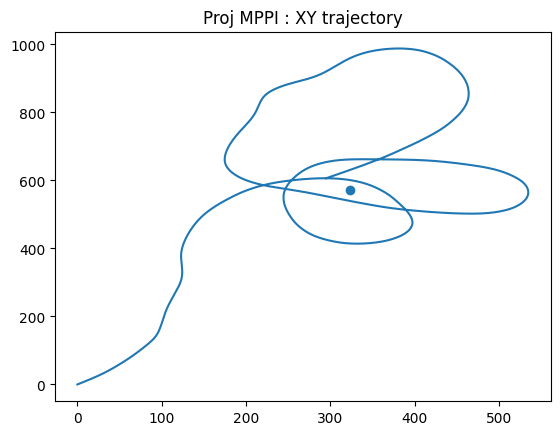

In [18]:
plt.figure()
plt.plot(states_proj_global_trained[case_num,:,0],states_proj_global_trained[case_num,:,1])
# plt.plot(x_proj_dataset,y_proj_dataset)
plt.scatter(goal_location[case_num,0],goal_location[case_num,1])
plt.title('Proj MPPI : XY trajectory')
plt.show()

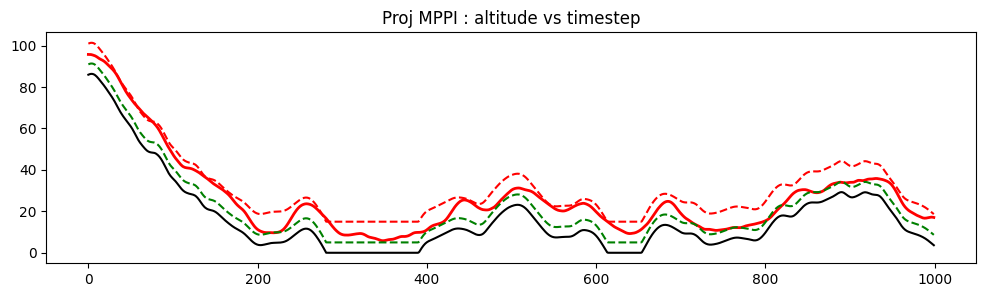

In [19]:
plt.figure(figsize=(12, 3))
plt.plot(states_proj_global_trained[case_num,:,2],linewidth=2,color = 'red')
plt.plot(z_terrain_proj_trained[case_num,:],color = 'black')
plt.plot(z_terrain_proj_trained[case_num,:] + terrain_lower,linestyle='--',color = 'green')
plt.plot(z_terrain_proj_trained[case_num,:] + terrain_upper,linestyle='--',color = 'red')
plt.title('Proj MPPI : altitude vs timestep')
plt.show()

In [20]:
# # ### Velocity/pitch/roll proj mppi ###

# plt.figure()
# plt.plot(controls_proj[:,:,0].T)
# plt.axhline(y=v_max, color='red', linestyle='--')
# plt.axhline(y=v_min, color='red', linestyle='--')
# plt.title('Velocity')
# plt.show()

# plt.figure()
# plt.plot(controls_dot_proj[:,:,0].T)
# plt.axhline(y=vdot_max, color='red', linestyle='--')
# plt.axhline(y=vdot_min, color='red', linestyle='--')
# plt.title('Velocity dot')
# plt.show()

# plt.figure()
# plt.plot(controls_ddot_proj[:,:,0].T)
# plt.axhline(y=vddot_max, color='red', linestyle='--')
# plt.axhline(y=vddot_min, color='red', linestyle='--')
# plt.title('Velocity ddot')
# plt.show()

# plt.figure()
# plt.plot(controls_proj[:,:,1].T)
# plt.axhline(y=pitch_max, color='red', linestyle='--')
# plt.axhline(y=pitch_min, color='red', linestyle='--')
# plt.title('Pitch')
# plt.show()

# plt.figure()
# plt.plot(controls_dot_proj[:,:,1].T)
# plt.axhline(y=pitchdot_max, color='red', linestyle='--')
# plt.axhline(y=pitchdot_min, color='red', linestyle='--')
# plt.title('Pitch dot')
# plt.show()

# plt.figure()
# plt.plot(controls_ddot_proj[:,:,1].T)
# plt.axhline(y=pitchddot_max, color='red', linestyle='--')
# plt.axhline(y=pitchddot_min, color='red', linestyle='--')
# plt.title('Pitch ddot')
# plt.show()  

# plt.figure()
# plt.plot(controls_proj[:,:,2].T)
# plt.axhline(y=roll_max, color='red', linestyle='--')
# plt.axhline(y=roll_min, color='red', linestyle='--')
# plt.title('Roll')
# plt.show()

# plt.figure()
# plt.plot(controls_dot_proj[:,:,2].T)
# plt.axhline(y=rolldot_max, color='red', linestyle='--')
# plt.axhline(y=rolldot_min, color='red', linestyle='--')
# plt.title('Roll dot')
# plt.show()

# plt.figure()
# plt.plot(controls_ddot_proj[:,:,2].T)
# plt.axhline(y=rollddot_max, color='red', linestyle='--')
# plt.axhline(y=rollddot_min, color='red', linestyle='--')
# plt.title('Roll ddot')
# plt.show()

In [21]:
# # %matplotlib widget

# fig2 = plt.figure()
# ax2 = plt.axes(projection='3d')

# # x = np.linspace(-300,1000)
# # y = np.linspace(-300,1000)
# # X,Y = np.meshgrid(x,y)
# # # z = 100*(0.1*jnp.cos(0.01*X) + 0.1*jnp.sin(0.01*Y))
# # z = 40*(0.7*jnp.cos(0.016*X) + 0.4*jnp.sin(0.016*Y))
# # # z = 75*(0.1*jnp.cos(0.035*X) + 0.1*jnp.sin(0.035*Y))
# # z = jnp.clip(z,0,20)

# print(x.shape)
# ax2.plot_surface(x, y, terrain_altitude,
#                        linewidth=0, antialiased=False,alpha = 0.1)
# ax2.scatter(y_goal,x_goal,z_goal)
# ax2.plot(states_proj_global[case_num,:,1],states_proj_global[case_num,:,0],states_proj_global[case_num,:,2],linewidth=3)
# plt.title('Proj MPPI : trajectory')
# plt.show()

In [22]:
# # %matplotlib widget


# fig = plt.figure()
# ax = plt.axes(projection='3d')

# # x = np.linspace(-300,1000)
# # y = np.linspace(-300,1000)
# # X,Y = np.meshgrid(x,y)
# # # z = 100*(0.1*jnp.cos(0.01*X) + 0.1*jnp.sin(0.01*Y))
# # z = 40*(0.7*jnp.cos(0.016*X) + 0.4*jnp.sin(0.016*Y))
# # # z = 75*(0.1*jnp.cos(0.035*X) + 0.1*jnp.sin(0.035*Y))
# # z = jnp.clip(z,0,20)
# ax.plot_surface(x, y, terrain_altitude,
#                        linewidth=0, antialiased=False,alpha = 0.1)
# ax.scatter(x_goal,y_goal,z_goal)
# ax.plot(states_base_global[case_num,:,0],states_base_global[case_num,:,1],states_base_global[case_num,:,2],linewidth=3)
# plt.title('Baseline MPPI : trajectory')
# plt.show()

In [23]:
# plt.figure(12)
# plt.plot(opt_traj[:,:,0].T,opt_traj[:,:,1].T)
# plt.title('Optimal trajectory rollout')
# plt.show()



In [24]:
# min_distance_goal_base = np.zeros(num_case)
# for i in range(num_case):
#     dist_goal_base = np.sqrt((states_base_global[i,:,0] - goal_location[i,0])**2+(states_base_global[i,:,1]-goal_location[i,1])**2+
#     (states_base_global[i,:,2]-goal_location[i,2])**2)
#     min_distance_goal_base[i] = np.min(dist_goal_base)
# mean_dist_goal_base = np.mean(min_distance_goal_base)
# print("mean_dist_goal_base",mean_dist_goal_base)

# min_distance_goal_proj = np.zeros(num_case)
# for i in range(num_case):
#     dist_goal_proj = np.sqrt((states_proj_global[i,:,0] - goal_location[i,0])**2+(states_proj_global[i,:,1]-goal_location[i,1])**2+
#     (states_proj_global[i,:,2]-goal_location[i,2])**2)
#     min_distance_goal_proj[i] = np.min(dist_goal_proj)
# mean_dist_goal_proj = np.mean(min_distance_goal_proj)
# print("mean_dist_goal_proj",mean_dist_goal_proj)

In [25]:
# np.savez('/home/edvin/Desktop/codes_main/CEM_UAV/mppi/mppi_main/training/data/terrain_trained_250_2_iterations',
# controls_proj=controls_proj,dot_proj=controls_dot_proj,ddot_proj=controls_ddot_proj,states_proj_global=states_proj_global,z_terrain_proj=z_terrain_proj,
# min_distance_goal_proj=min_distance_goal_proj,mean_dist_goal_proj=mean_dist_goal_proj,con_viol_vel_proj=con_viol_vel_proj,con_viol_vel_dot_proj=con_viol_vel_dot_proj,
# con_viol_vel_ddot_proj=con_viol_vel_ddot_proj,con_viol_pitch_proj=con_viol_pitch_proj,con_viol_pitch_dot_proj=con_viol_pitch_dot_proj,con_viol_pitch_ddot_proj=con_viol_pitch_ddot_proj,
# con_viol_roll_proj=con_viol_roll_proj,con_viol_roll_dot_proj=con_viol_roll_dot_proj,con_viol_roll_ddot_proj=con_viol_roll_ddot_proj,mean_con_viol_vel_proj=mean_con_viol_vel_proj,
# mean_con_viol_vel_dot_proj=mean_con_viol_vel_dot_proj,mean_con_viol_vel_ddot_proj=mean_con_viol_vel_ddot_proj,mean_con_viol_pitch_proj=mean_con_viol_pitch_proj,
# mean_con_viol_pitch_dot_proj=mean_con_viol_pitch_dot_proj,mean_con_viol_pitch_ddot_proj=mean_con_viol_pitch_ddot_proj,mean_con_viol_roll_proj=mean_con_viol_roll_proj,
# mean_con_viol_roll_dot_proj=mean_con_viol_roll_dot_proj,mean_con_viol_roll_ddot_proj=mean_con_viol_roll_ddot_proj,max_altitude_viol_proj=max_altitude_viol_proj,
# min_altitude_viol_proj=min_altitude_viol_proj,mean_max_altitude_viol_proj=mean_max_altitude_viol_proj,mean_min_altitude_viol_proj=mean_min_altitude_viol_proj,
# states_train=states_train,mean_proj_values=mean_proj_values,mean_mean_dist_goal_proj=mean_mean_dist_goal_proj,success_proj_overall=success_proj_overall,
# tot_con_viol_vel_proj=tot_con_viol_vel_proj,
# tot_con_viol_vel_dot_proj=tot_con_viol_vel_dot_proj,
# tot_con_viol_vel_ddot_proj=tot_con_viol_vel_ddot_proj,
# tot_con_viol_pitch_proj=tot_con_viol_pitch_proj,
# tot_con_viol_pitch_dot_proj=tot_con_viol_pitch_dot_proj,
# tot_con_viol_pitch_ddot_proj=tot_con_viol_pitch_ddot_proj,
# tot_con_viol_roll_proj=tot_con_viol_roll_proj,
# tot_con_viol_roll_dot_proj=tot_con_viol_roll_dot_proj,
# tot_con_viol_roll_ddot_proj=tot_con_viol_roll_ddot_proj,
# goal_location=goal_location)

# np.savez('/home/edvin/Desktop/codes_main/CEM_UAV/mppi/mppi_main/training/data/tcomparison_baseline_learined_250_2_iter',
# controls_proj_proj_trained=controls_proj_trained,dot_proj_trained=controls_dot_proj_trained,ddot_proj_trained=controls_ddot_proj_trained,states_proj_global_trained=states_proj_global_trained,z_terrain_projtrained=z_terrain_proj_trained,
# min_distance_goal_proj_trained=min_distance_goal_proj_trained,mean_dist_goal_proj_trained=mean_dist_goal_proj_trained,con_viol_vel_proj_trained=con_viol_vel_proj_trained,con_viol_vel_dot_proj_trained=con_viol_vel_dot_proj_trained,
# con_viol_vel_ddot_proj_trained=con_viol_vel_ddot_proj_trained,con_viol_pitch_proj_trained=con_viol_pitch_proj_trained,con_viol_pitch_dot_proj_trained=con_viol_pitch_dot_proj_trained,con_viol_pitch_ddot_proj_trained=con_viol_pitch_ddot_proj_trained,
# con_viol_roll_proj_trained=con_viol_roll_proj_trained,con_viol_roll_dot_proj_trained=con_viol_roll_dot_proj_trained,con_viol_roll_ddot_proj_trained=con_viol_roll_ddot_proj_trained,mean_con_viol_vel_proj_trained=mean_con_viol_vel_proj_trained,
# mean_con_viol_vel_dot_proj_trained=mean_con_viol_vel_dot_proj_trained,mean_con_viol_vel_ddot_proj_trained=mean_con_viol_vel_ddot_proj_trained,mean_con_viol_pitch_proj_trained=mean_con_viol_pitch_proj_trained,
# mean_con_viol_pitch_dot_proj_trained=mean_con_viol_pitch_dot_proj_trained,mean_con_viol_pitch_ddot_proj_trained=mean_con_viol_pitch_ddot_proj_trained,mean_con_viol_roll_proj_trained=mean_con_viol_roll_proj_trained,
# mean_con_viol_roll_dot_proj_trained=mean_con_viol_roll_dot_proj_trained,mean_con_viol_roll_ddot_proj_trained=mean_con_viol_roll_ddot_proj_trained,max_altitude_viol_proj_trained=max_altitude_viol_proj_trained,
# min_altitude_viol_proj_trained=min_altitude_viol_proj_trained,mean_max_altitude_viol_proj_trained=mean_max_altitude_viol_proj_trained,mean_min_altitude_viol_proj_trained=mean_min_altitude_viol_proj_trained,
# states_train_trained=states_train_trained,mean_proj_values_trained=mean_proj_values_trained,mean_mean_dist_goal_proj_trained=mean_mean_dist_goal_proj_trained,success_proj_overall_trained=success_proj_overall_trained,
# tot_con_viol_vel_proj_trained=tot_con_viol_vel_proj_trained,
# tot_con_viol_vel_dot_proj_trained=tot_con_viol_vel_dot_proj_trained,
# tot_con_viol_vel_ddot_proj_trained=tot_con_viol_vel_ddot_proj_trained,
# tot_con_viol_pitch_proj_trained=tot_con_viol_pitch_proj_trained,
# tot_con_viol_pitch_dot_proj_trained=tot_con_viol_pitch_dot_proj_trained,
# tot_con_viol_pitch_ddot_proj_trained=tot_con_viol_pitch_ddot_proj_trained,
# tot_con_viol_roll_proj_trained=tot_con_viol_roll_proj_trained,
# tot_con_viol_roll_dot_proj_trained=tot_con_viol_roll_dot_proj_trained,
# tot_con_viol_roll_ddot_proj_trained=tot_con_viol_roll_ddot_proj_trained,
# controls_proj_proj_baseline=controls_proj_baseline,dot_proj_baseline=controls_dot_proj_baseline,ddot_proj_baseline=controls_ddot_proj_baseline,states_proj_global_baseline=states_proj_global_baseline,z_terrain_proj_baseline=z_terrain_proj_baseline,
# min_distance_goal_proj_baseline=min_distance_goal_proj_baseline,mean_dist_goal_proj_baseline=mean_dist_goal_proj_baseline,con_viol_vel_proj_baseline=con_viol_vel_proj_baseline,con_viol_vel_dot_proj_baseline=con_viol_vel_dot_proj_baseline,
# con_viol_vel_ddot_proj_baseline=con_viol_vel_ddot_proj_baseline,con_viol_pitch_proj_baseline=con_viol_pitch_proj_baseline,con_viol_pitch_dot_proj_baseline=con_viol_pitch_dot_proj_baseline,con_viol_pitch_ddot_proj_baseline=con_viol_pitch_ddot_proj_baseline,
# con_viol_roll_proj_baseline=con_viol_roll_proj_baseline,con_viol_roll_dot_proj_baseline=con_viol_roll_dot_proj_baseline,con_viol_roll_ddot_proj_baseline=con_viol_roll_ddot_proj_baseline,mean_con_viol_vel_proj_baseline=mean_con_viol_vel_proj_baseline,
# mean_con_viol_vel_dot_proj_baseline=mean_con_viol_vel_dot_proj_baseline,mean_con_viol_vel_ddot_proj_baseline=mean_con_viol_vel_ddot_proj_baseline,mean_con_viol_pitch_proj_baseline=mean_con_viol_pitch_proj_baseline,
# mean_con_viol_pitch_dot_proj_baseline=mean_con_viol_pitch_dot_proj_baseline,mean_con_viol_pitch_ddot_proj_baseline=mean_con_viol_pitch_ddot_proj_baseline,mean_con_viol_roll_proj_baseline=mean_con_viol_roll_proj_baseline,
# mean_con_viol_roll_dot_proj_baseline=mean_con_viol_roll_dot_proj_baseline,mean_con_viol_roll_ddot_proj_baseline=mean_con_viol_roll_ddot_proj_baseline,max_altitude_viol_proj_baseline=max_altitude_viol_proj_baseline,
# min_altitude_viol_proj_baseline=min_altitude_viol_proj_baseline,mean_max_altitude_viol_proj_baseline=mean_max_altitude_viol_proj_baseline,mean_min_altitude_viol_proj_baseline=mean_min_altitude_viol_proj_baseline,
# states_train_baseline=states_train_baseline,mean_proj_values_baseline=mean_proj_values_baseline,mean_mean_dist_goal_proj_baseline=mean_mean_dist_goal_proj_baseline,success_proj_overall_baseline=success_proj_overall_baseline,
# tot_con_viol_vel_proj_baseline=tot_con_viol_vel_proj_baseline,
# tot_con_viol_vel_dot_proj_baseline=tot_con_viol_vel_dot_proj_baseline,
# tot_con_viol_vel_ddot_proj_baseline=tot_con_viol_vel_ddot_proj_baseline,
# tot_con_viol_pitch_proj_baseline=tot_con_viol_pitch_proj_baseline,
# tot_con_viol_pitch_dot_proj_baseline=tot_con_viol_pitch_dot_proj_baseline,
# tot_con_viol_pitch_ddot_proj_baseline=tot_con_viol_pitch_ddot_proj_baseline,
# tot_con_viol_roll_proj_baseline=tot_con_viol_roll_proj_baseline,
# tot_con_viol_roll_dot_proj_baseline=tot_con_viol_roll_dot_proj_baseline,
# tot_con_viol_roll_ddot_proj_baseline=tot_con_viol_roll_ddot_proj_baseline,
# goal_location=goal_location)




In [26]:
# import seaborn as sns
# sns.set_theme()

# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"

# plt.figure(figsize=(12, 3))
# plt.plot(controls_ddot_proj[case_num,:,2],linewidth=3,label='$\pi$-MPPI')
# plt.plot(ddot_base[case_num,:,2],linewidth=3,label='MPPI')
# plt.legend(loc='upper right', borderpad=0.01, labelspacing=0.01)
# plt.axhline(y=rollddot_max, color='red', linestyle='--')
# plt.axhline(y=rollddot_min, color='red', linestyle='--')
# plt.xlabel('MPPI Iteration')
# plt.ylabel('$\ddot{\phi}\ \ {(rad/s}^2)$ ')

# plt.figure(figsize=(12, 3))
# plt.plot(controls_ddot_proj[case_num,:,1],linewidth=3,label='$\pi$-MPPI')
# plt.plot(ddot_base[case_num,:,1],linewidth=3)
# plt.axhline(y=pitchddot_max, color='red', linestyle='--')
# plt.axhline(y=pitchddot_min, color='red', linestyle='--')
# plt.legend(loc='upper right', borderpad=0.01, labelspacing=0.01)
# plt.xlabel('MPPI Iteration')
# plt.ylabel('$\ddot{\theta}\ \ {(rad/s}^2)$ ')


# plt.figure(figsize=(12, 3))
# plt.plot(controls_ddot_proj[case_num,:,0],linewidth=1,label='$\pi$-MPPI')
# plt.plot(ddot_base[case_num,:,0],linewidth=1.5)
# plt.axhline(y=vddot_max, color='red', linestyle='--')
# plt.axhline(y=vddot_min, color='red', linestyle='--')
# plt.legend(loc='upper right', borderpad=0.01, labelspacing=0.01)
# plt.xlabel('MPPI Iteration')
# plt.ylabel('$\ddot{V}\ \ {(rad/s}^3)$ ')
# plt.show()

In [27]:
# np.savez('./mppi/new_mppi/data/c_samples/c_samples_terrain_n250',raw_sample_values=raw_sample_values,proj_sample_values=proj_sample_values)